<a href="https://colab.research.google.com/github/shazzad-hasan/ethereum-fraud-detection/blob/main/data-preparation/time_series_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [17]:
df = pd.read_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/new_ts_features_only.csv')

In [18]:
df.head()

,Unnamed: 0,Address,adjusted_eth_value__variance_larger_than_standard_deviation,adjusted_eth_value__has_duplicate_max,adjusted_eth_value__has_duplicate_min,adjusted_eth_value__has_duplicate,adjusted_eth_value__sum_values,adjusted_eth_value__abs_energy,adjusted_eth_value__mean_abs_change,adjusted_eth_value__mean_second_derivative_central,...,adjusted_eth_value__ratio_beyond_r_sigma__r_3,adjusted_eth_value__ratio_beyond_r_sigma__r_5,adjusted_eth_value__ratio_beyond_r_sigma__r_6,adjusted_eth_value__ratio_beyond_r_sigma__r_10,adjusted_eth_value__count_above__t_0,adjusted_eth_value__count_below__t_0,adjusted_eth_value__fourier_entropy__bins_2,adjusted_eth_value__query_similarity_count__query_None__threshold_0.0,"adjusted_eth_value__matrix_profile__feature_""min""__threshold_0.98",FLAG
0,0,0x000000000532b45f47779fce440748893b257865,1.0,0.0,1.0,1.0,0.002552,5587.558824,5.789218,-0.237797,...,0.000000,0.000000,0.000000,0.0,0.869565,0.130435,0.450561,0.0,0.000000,1
1,1,0x00000000072d54638c2c2a3da3f715360269eea1,1.0,0.0,0.0,1.0,-0.771623,52949.011552,10.615707,2.037385,...,0.018868,0.018868,0.018868,0.0,0.811321,0.433962,0.479166,0.0,0.634623,1
2,2,0x0000000086c5d614bec59dfd2c9b88f7cb57f23c,1.0,0.0,0.0,0.0,-9.999391,4444.468528,20.771913,-8.228324,...,0.000000,0.000000,0.000000,0.0,0.833333,0.166667,0.562335,0.0,0.000000,1
3,3,0x00000000d029a3ed50d891b9afd74b034179082e,0.0,0.0,0.0,0.0,0.004158,0.495859,0.995842,0.000000,...,0.000000,0.000000,0.000000,0.0,0.500000,0.500000,-0.000000,0.0,0.000000,1
4,4,0x00000e32e51011e28958d4696627c82c3dacd5a6,0.0,0.0,0.0,1.0,-0.035777,0.351082,0.098646,-0.000387,...,0.023256,0.000000,0.000000,0.0,0.720930,0.302326,0.625491,0.0,0.000000,1


In [19]:
df.columns

Index(['Unnamed: 0', 'Address',
       'adjusted_eth_value__variance_larger_than_standard_deviation',
       'adjusted_eth_value__has_duplicate_max',
       'adjusted_eth_value__has_duplicate_min',
       'adjusted_eth_value__has_duplicate', 'adjusted_eth_value__sum_values',
       'adjusted_eth_value__abs_energy', 'adjusted_eth_value__mean_abs_change',
       'adjusted_eth_value__mean_second_derivative_central',
       ...
       'adjusted_eth_value__ratio_beyond_r_sigma__r_3',
       'adjusted_eth_value__ratio_beyond_r_sigma__r_5',
       'adjusted_eth_value__ratio_beyond_r_sigma__r_6',
       'adjusted_eth_value__ratio_beyond_r_sigma__r_10',
       'adjusted_eth_value__count_above__t_0',
       'adjusted_eth_value__count_below__t_0',
       'adjusted_eth_value__fourier_entropy__bins_2',
       'adjusted_eth_value__query_similarity_count__query_None__threshold_0.0',
       'adjusted_eth_value__matrix_profile__feature_"min"__threshold_0.98',
       'FLAG'],
      dtype='object', lengt

In [20]:
labels = df[['FLAG']]

df.drop_duplicates(subset=["Address"], inplace=True)
df.drop(['Unnamed: 0', 'Address', 'FLAG'], axis=1, inplace=True)

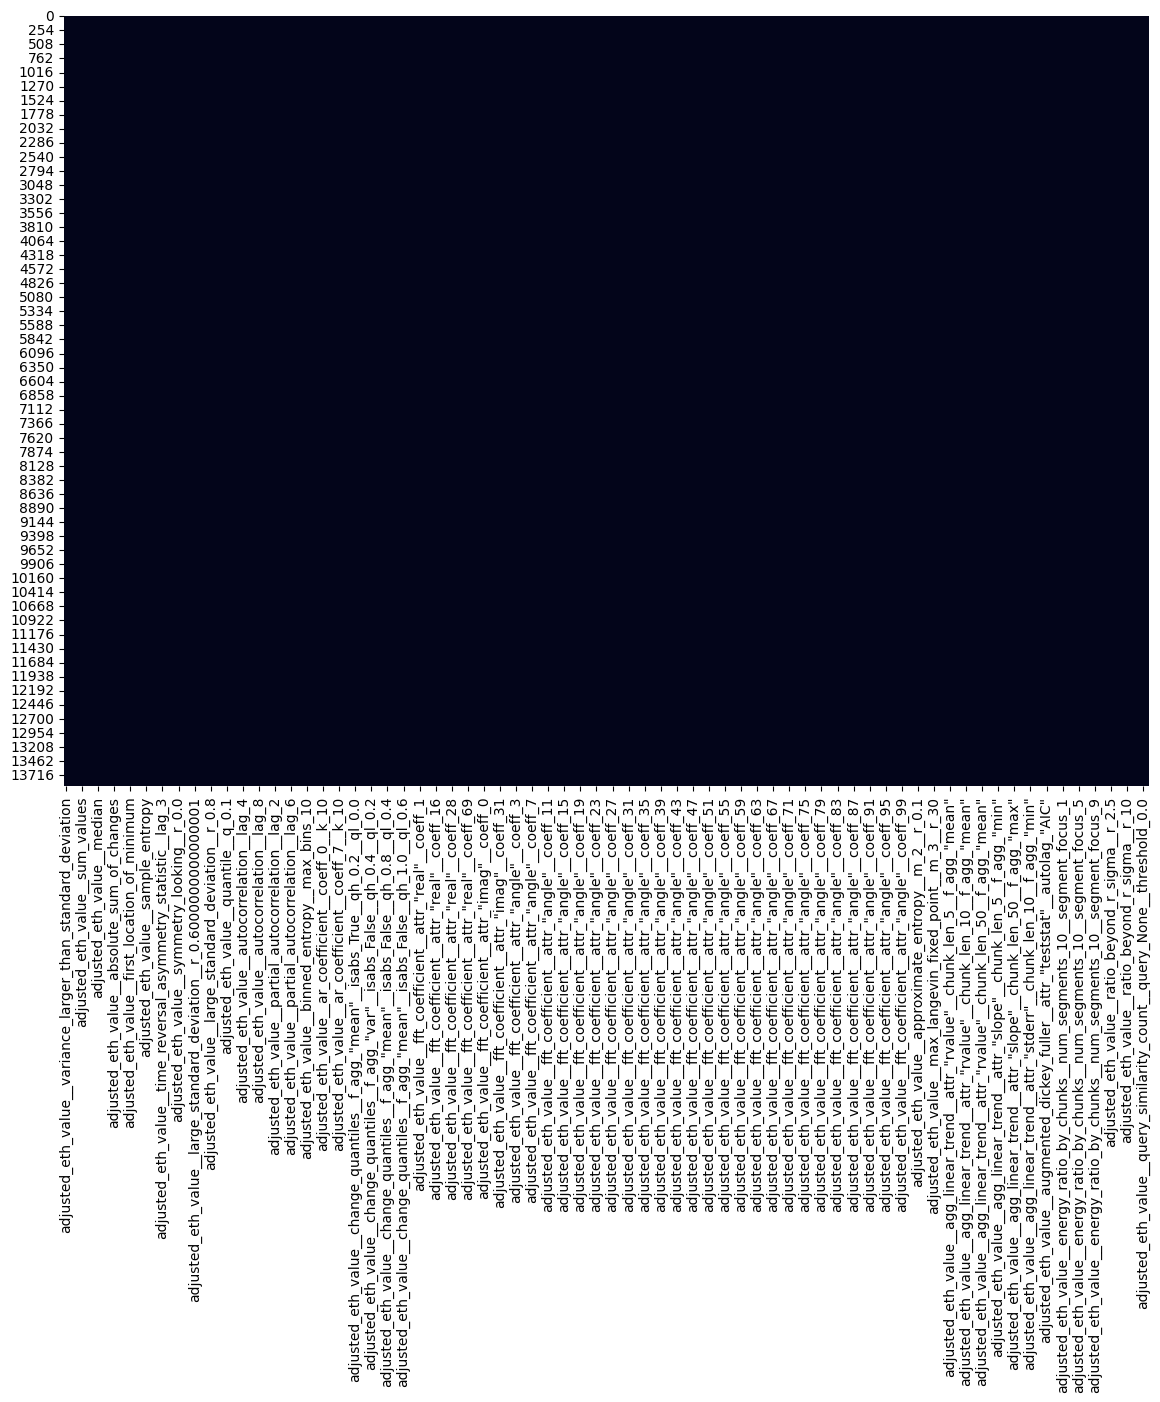

In [21]:
# Visualize missing values
plt.figure(figsize=(14,10))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [22]:
positions = df.isin([np.inf, -np.inf])
inf_positions = df.loc[positions.any(axis=1), positions.any(axis=0)]

In [23]:
# Replace missing values with median
df.fillna(df.median(), inplace=True)

# Drop features that contains inf
features_to_drop = ['adjusted_eth_value__sample_entropy','adjusted_eth_value__augmented_dickey_fuller__attr_"teststat"__autolag_"AIC"']
df.drop(features_to_drop, axis=1, inplace=True)

In [24]:
train_x, test_x, train_y, test_y = train_test_split(df, labels, test_size=0.4, random_state=0)
xgb = XGBClassifier(seed=42)

params = {
    'objective': ['binary:logistic'],
    'max_depth': [4],
    'n_estimators': [1000],
    'learning_rate': [0.01],
    'subsample': [0.3],
    'colsample_bytree':[0.3]
}

clf = GridSearchCV(estimator=xgb,
                   param_grid=params,
                   cv=5,
                   n_jobs=-1,
                   scoring='f1')
clf.fit(train_x, train_y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3], 'learning_rate': [0.01],
                         'max_depth': [4], 'n_estimators': [1000],
                         'objective': ['binary:logistic'], 'subsample': [0.3]},
             scoring='f1')

In [25]:
features = df.columns.tolist()

In [26]:
feat_importances = clf.best_estimator_.feature_importances_
sorted_indices = np.argsort(feat_importances)[::-1]
sorted_features = [features[idx] for idx in sorted_indices]
sorted_importances = feat_importances[sorted_indices]

for feature, importance in zip(sorted_features, sorted_importances):
    print(f"{feature} : {importance}")

adjusted_eth_value__absolute_sum_of_changes : 0.019576625898480415
adjusted_eth_value__mean_abs_change : 0.018903708085417747
adjusted_eth_value__ratio_value_number_to_time_series_length : 0.018859056755900383
adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0 : 0.017724715173244476
adjusted_eth_value__max_langevin_fixed_point__m_3__r_30 : 0.016796471551060677
adjusted_eth_value__has_duplicate_min : 0.013386868871748447
adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_1 : 0.011779091320931911
adjusted_eth_value__count_below__t_0 : 0.011384930461645126
adjusted_eth_value__autocorrelation__lag_8 : 0.01093865092843771
adjusted_eth_value__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min" : 0.010738608427345753
adjusted_eth_value__autocorrelation__lag_6 : 0.01073269359767437
adjusted_eth_value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max" : 0.01036450732499361
adjusted_eth_value__matrix_profile__feature_"min"__thre

In [27]:
top_10_indices = sorted_indices[:10]

top_10_features = [features[idx] for idx in top_10_indices]
top_10_importances = feat_importances[top_10_indices]

for feature in top_10_features:
    print(f"{feature}")

adjusted_eth_value__absolute_sum_of_changes
adjusted_eth_value__mean_abs_change
adjusted_eth_value__ratio_value_number_to_time_series_length
adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0
adjusted_eth_value__max_langevin_fixed_point__m_3__r_30
adjusted_eth_value__has_duplicate_min
adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_1
adjusted_eth_value__count_below__t_0
adjusted_eth_value__autocorrelation__lag_8
adjusted_eth_value__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"


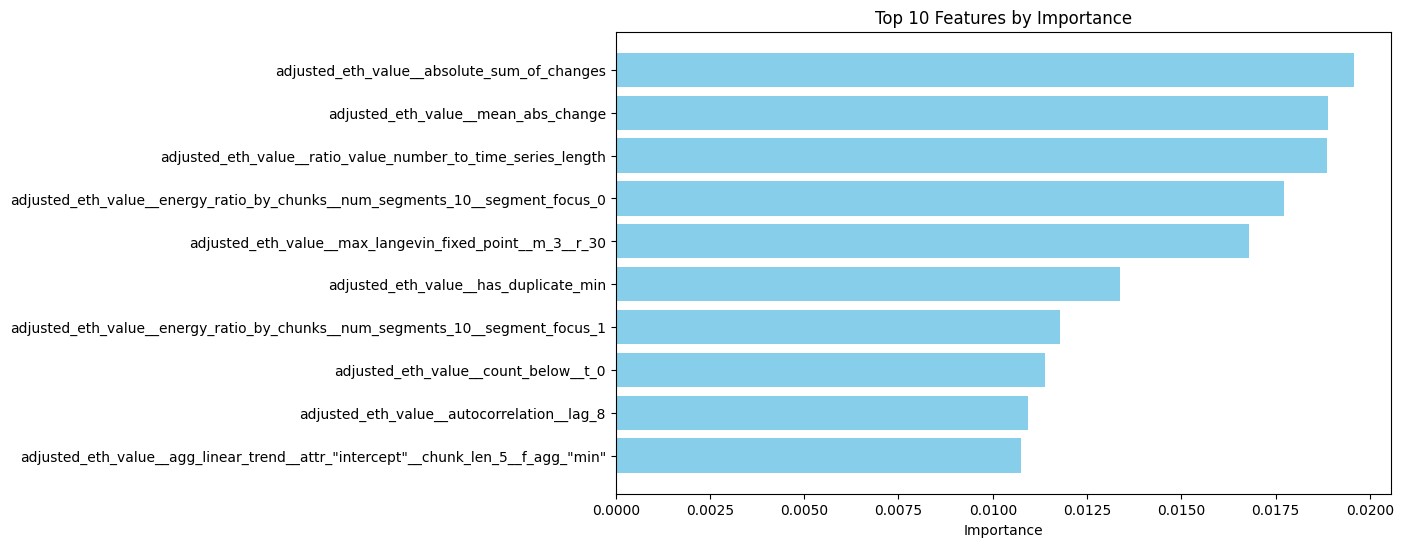

In [28]:
plt.figure(figsize=(10, 6))
plt.barh(top_10_features, top_10_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Features by Importance')
plt.gca().invert_yaxis()

plt.show()

In [30]:
df.to_csv('/content/drive/MyDrive/ethereum-fraud-detection/processed-data/cleaned-time-series-data.csv')